In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from components.positional import add_timing_signal_nd

In [2]:
def embedding_initializer(shape, dtype):
    E = tf.random.uniform(shape, minval=-1.0, maxval=1.0, dtype=dtype)
    E = tf.nn.l2_normalize(E, -1)
    return E

In [3]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [4]:
class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, id_end):
        super(Decoder, self). __init__()
        self.units = units
        # comes from Vocab
        self._id_end = id_end

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTMCell(self.units)

        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

        self.start_token = tf.Variable(initial_value=embedding_initializer([embedding_dim], dtype=tf.float32), 
                                       dtype=tf.float32, shape=[embedding_dim],)

        self.decoder = tfa.seq2seq.BeamSearchDecoder(
            self.lstm, beam_width=3, output_layer=self.fc1, )

    def call(self, x, features, hidden):
        # defining attention as seperate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passsing concatenated vector to LSTM
        output, state = self.decoder(x, start_tokens=self.start_token)

        # shape == (batch_size, max_length, hidden_size)
        # x = self.fc1(output)

        # x shape == (batch_size, max_length, hidden_size)
        x = tf.reshape(output, (-1, x.shape[2]))

        # output shape == (batch_size, * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [5]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(padding='same'),
            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(padding='same'),
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 1), strides=(2, 1), padding='same'),
            tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2), padding='same'),
            tf.keras.layers.Conv2D(512, 3, activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Lambda(add_timing_signal_nd),
            tf.keras.layers.Dense(embedding_dim),
        ])
    def call(self, x):
        x = self.encoder(x)
        x = tf.nn.relu(x)

        return x

In [6]:
from model.utils.data_generator import DataGenerator
from model.utils.general import Config
from model.utils.text import Vocab
from model.utils.image import greyscale

In [7]:
data = "configs/data_small.json"
vocab = "configs/vocab_small.json"
training = "configs/training_small.json"
model = "configs/model.json"
output = "results/small/"

In [8]:
config = Config([data, vocab, training, model])

In [9]:
vocab = Vocab(config)

In [10]:
train_set = DataGenerator(path_formulas=config.path_formulas_train, dir_images=config.dir_images_train,
                         img_prepro=greyscale, max_iter=config.max_iter, bucket=config.bucket_train,
                         path_matching=config.path_matching_train, max_len=config.max_length_formula,
                         form_prepro=vocab.form_prepro)

Loaded 10 formulas from data/small.formulas.norm.txt
Bucketing the dataset...
- done.


In [11]:
val_set = DataGenerator(path_formulas=config.path_formulas_val,
                       dir_images=config.dir_images_val, img_prepro=greyscale,
                       max_iter=config.max_iter, bucket=config.bucket_val,
                       path_matching=config.path_matching_val, max_len=config.max_length_formula,
                       form_prepro=vocab.form_prepro)

Loaded 10 formulas from data/small.formulas.norm.txt
Bucketing the dataset...
- done.


In [14]:
encoder = CNN_Encoder(config.attn_cell_config['dim_embeddings'])

In [15]:
decoder = Decoder(config.attn_cell_config['dim_embeddings'], config.attn_cell_config['num_units'], len(vocab.id_to_tok), vocab.id_end)


In [16]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [19]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [20]:
start_epoch = 0

if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restore to latest cehckpoint
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [36]:
import pathlib

In [39]:
data_dir = pathlib.Path("data/small")

In [40]:
image_count = len(list(data_dir.glob("*.png")))

In [42]:
import PIL

In [112]:
imgs = list(data_dir.glob("*.png"))

In [113]:
imgs.reverse()

In [105]:
import os

In [114]:
imgs_paths = []
for img in imgs:
    imgs_paths.append(os.fspath(img))

In [115]:
imgs

[PosixPath('data/small/0.png'),
 PosixPath('data/small/1.png'),
 PosixPath('data/small/3.png'),
 PosixPath('data/small/2.png'),
 PosixPath('data/small/6.png'),
 PosixPath('data/small/7.png'),
 PosixPath('data/small/5.png'),
 PosixPath('data/small/4.png'),
 PosixPath('data/small/9.png'),
 PosixPath('data/small/8.png')]

In [129]:
imgs_paths = sorted(set(imgs_paths))

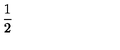

In [132]:
PIL.Image.open(imgs_path[9])

In [61]:
lines = open("data/small.formulas.norm.txt", 'r').read().split('\n')

In [62]:
for i in range(len(lines)):
    lines[i] = "<start> " + lines[i] + " <end>" 

In [63]:
lines

['<start> \\alpha + \\beta <end>',
 '<start> \\frac { 1 } { 2 } <end>',
 '<start> \\frac { \\alpha } { \\beta } <end>',
 '<start> 1 + 2 <end>',
 '<start> \\alpha + \\beta <end>',
 '<start> \\frac { 1 } { 2 } <end>',
 '<start> \\frac { \\alpha } { \\beta } <end>',
 '<start> 1 + 2 <end>',
 '<start> \\alpha + \\beta <end>',
 '<start> \\frac { 1 } { 2 } <end>']

## Tokenize

In [74]:
top_k = 400

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>")
tokenizer.fit_on_texts(lines)
train_seqs = tokenizer.texts_to_sequences(lines)

In [75]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [76]:
train_seqs = tokenizer.texts_to_sequences(lines)

In [77]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [78]:
# Find the maximum length of any formula in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [79]:
max_length = calc_max_length(train_seqs)

## Split Datasets

In [119]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img)
    return img, image_path

In [82]:
from sklearn.model_selection import train_test_split


In [83]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(imgs,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [133]:
encode_train = sorted(set(imgs_paths))

In [134]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

In [135]:
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

## Training

In [136]:
loss_plot = []

In [138]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            
            loss += loss_function(target[:, i], predictions)
            
            dec_input = tf.expand_dims(target[:, i], 1)
            
        total_loss = (loss / int(target.shape[1]))
        
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        
        gradients = tape.gradient(loss, trainable_varaibles)
        
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
        return loss, total_loss
    

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
    
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
                  epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
        
    loss_plot.append(total_loss / num_steps)
    
    if epoch % 5 == 0:
        ckpt_manager.save()
        
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
